<h1>状態空間モデルの時間応答</h1>

Pythonによる制御工学入門 P107~

　伝達関数モデルでは、入力に対して出力がどのように変化するかに注目していましたが、状態空間モデルの場合は、出力の変化に加えて初期値が出力にどのような影響（初期値応答）を与えるかも見ることができます。（初期値鋭敏性？）  

Pythonで初期値応答を見たい場合は```x, t = initial(sys, Td, X0)```で見ることができます。  

引数の```sys```と```Td```は関数```step```と同じで、```X0```のみが初期状態を指します。初期状態が$0$とする場合はこの変数を省略することができます。  

戻り値の```x, t```は、```x```が状態の応答、```t```が時間になります。  
(```x```の各要素を見たい場合はスライスを利用すること！)

例として、以下の状態空間モデルを考えてみます。

```math
A = \begin{bmatrix}0 & 1 \\ -4 & -5 \end{bmatrix}, 
B = \begin{bmatrix}0 \\ 1 \end{bmatrix}, 
C = \begin{bmatrix}1 & 0 \\ 0 & 1 \end{bmatrix}, 
D = \begin{bmatrix}0 \\ 0 \end{bmatrix}
```

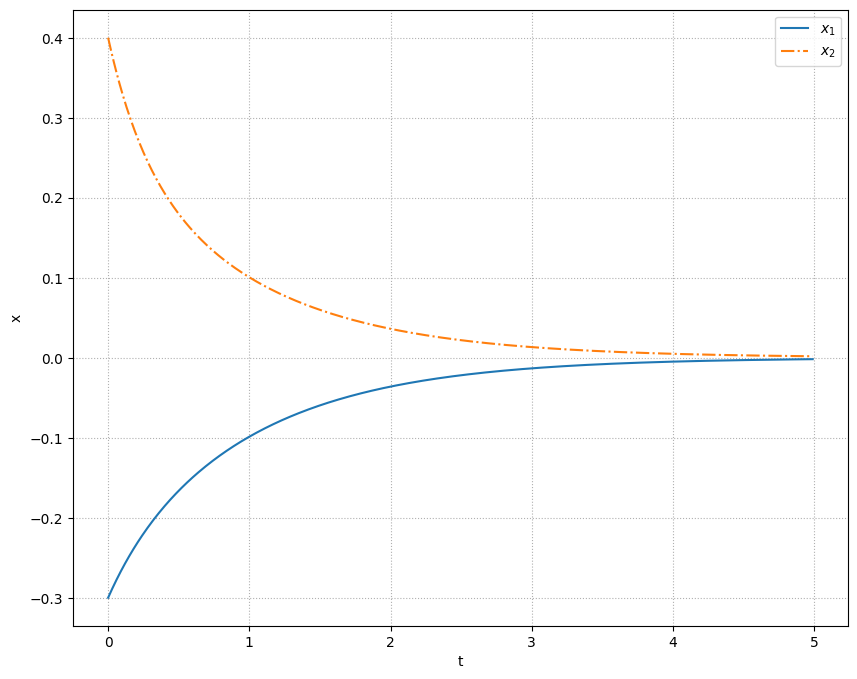

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from control.matlab import ss, step, initial, lsim
from plot import plot_set

# define the state space model.
A = [[0, 1], [-4, -5]]
B = [[0], [1]]
C = [[1, 0], [0, 1]]
D = [[0], [0]]

P = ss(A, B, C, D)

Td = np.arange(0, 5, 0.01)
X0 = [-0.3, 0.4]
x, t = initial(P, Td, X0)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, x[:, 0], label='$x_1$')
ax.plot(t, x[:, 1], ls='-.', label='$x_2$')
plot_set(ax, 't', 'x', 'best')

上記のモデルは以下の垂直駆動アームをモデル化したものになります。

```math

```
垂直駆動アームの場合、初期角度と初期角速度を与えて開始したとき、それ以降に何も入力がなければアームは粘性摩擦と重力の影響を受けて鉛直下向きに垂れ下がって静止します。  
とどのつまり、$x_s(t) → 0$、$x_2(t) → 0(t→\infty)$になります。

<h3>寄り道：行列指数関数（状態遷移行列）のPythonによる計算</h3>

次の微分方程式$\dot{x}(t)=ax(t)$の解は$x(t)=e^{at}x(0)$になり、この$a$を行列に置き換えた状態方程式$\dot{x}(t)=Ax(t)$の解は$x(t)=e^{At}x(0)$になります。  

この$e^{At}x(0)$は行列指数関数（状態遷移行列）で、以下のようになります。ここで、$I$は単位行列になります。
```math
\begin{align}
e^{At}& = I + At + \frac{A^2t^2}{2!} + \frac{A^3t^3}{3!} + ... \\
& = L^{-1} [(sI - A)^{-1}]
\end{align}
```

この行列指数関数を計算できれば状態方程式の振舞いを求めることができます。  

手計算はチューリング完全であることは確かですが、ここは高度情報化社会の恩恵を最大限に利用して、コンピュータ・パワーにモノを言わせて計算させます。パワー！

In [8]:
import sympy as sp
import numpy as np

sp.init_printing()
s = sp.Symbol('s')
t = sp.Symbol('t', positive=True)

A = np.array([[0, 1], [-4, -5]])
G = s*sp.eye(2) - A

exp_At = sp.inverse_laplace_transform(sp.simplify(G.inv()), s, t)

print(f'Result of the Inverse Laplace Transform.')
display(exp_At)

Result of the Inverse Laplace Transform.


⎡     -t    -4⋅t       -t    -4⋅t  ⎤
⎢  4⋅ℯ     ℯ          ℯ     ℯ      ⎥
⎢  ───── - ─────      ─── - ─────  ⎥
⎢    3       3         3      3    ⎥
⎢                                  ⎥
⎢     -t      -4⋅t     -t      -4⋅t⎥
⎢  4⋅ℯ     4⋅ℯ        ℯ     4⋅ℯ    ⎥
⎢- ───── + ───────  - ─── + ───────⎥
⎣    3        3        3       3   ⎦

また、```scipy```を使うことである時間の行列指数関数を求めることもできます。以下の例は$t=5$のときの行列指数関数の値になります。

In [9]:
from scipy.linalg import expm

A = np.array([[0, 1], [-4, -5]])
t = 5

expm(A*t)

array([[ 0.00898393,  0.00224598],
       [-0.00898393, -0.00224598]])

こいつぁすげぇ！行列指数関数の逆ラプラス変換があっという間にできちまった！  

余談として、時間を刻んでいってどのように計算されるかを見ていきます。

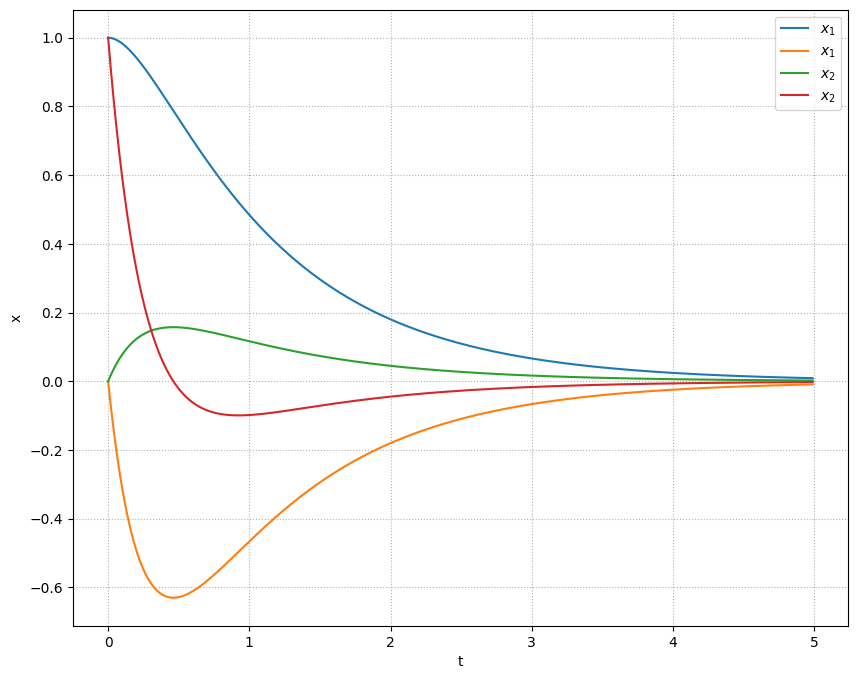

In [16]:
A = np.array([[0, 1], [-4, -5]])
Ts = np.arange(0, 5, 0.01)

ys = [expm(A*t) for t in Ts]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(Ts, [y[:, 0] for y in ys], label='$x_1$')
ax.plot(Ts, [y[:, 1] for y in ys], label='$x_2$')

plot_set(ax, 't', 'x', 'best')

~~なんかよくわからないものが計算されました~~

<h2>状態空間モデルの零状態応答</h2>

状態方程式$\dot{x}(t) = Ax(t) + Bu(t)$の解は次の通りです。

```math
x(t) = e^{At}x(0) + \int_{0}^{t}e^{A(t-\tau)}Bu(\tau)d\tau \qquad(t\geq0)
```
上の式から$e^{At}x(0)$を**零入力応答**、$\int_{0}^{t}e^{A(t-\tau)}Bu(\tau)$を**零状態応答**と呼びます。

ここで、初期値$x(0) = [0 0]^T$として、入力を$u(t)=1 (t\geq0)$としたときの零状態応答は以下の通りです。  

```math
x(t) = \int_{0}^{t}e^{A(t-\tau)}Bd\tau
```

この零状態応答を見てみることにします。

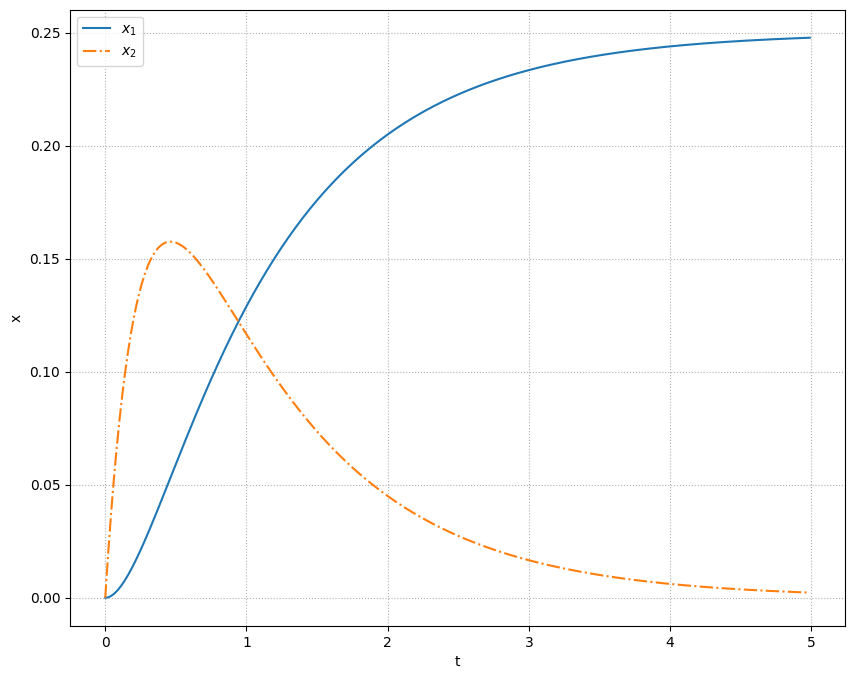

In [17]:
Td = np.arange(0, 5, 0.01)
x, t = step(P, Td)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t, x[:, 0], label='$x_1$')
ax.plot(t, x[:, 1], ls='-.', label='$x_2$')
plot_set(ax, 't', 'x', 'best')

続いて、零入力応答と零状態応答を足し合わせた時間応答を見てみます。時間応答は```lsim```関数を用いて計算できます。  

```lsim```関数は```y, t, x = lsim(sys, Ud, Td, X0)```で定義され、$y$がシステムの出力応答、$t$が時間、$x$が状態の応答として返る。このとき、$C$行列を単位行列とする場合、$y$は状態$x$と等価になります。

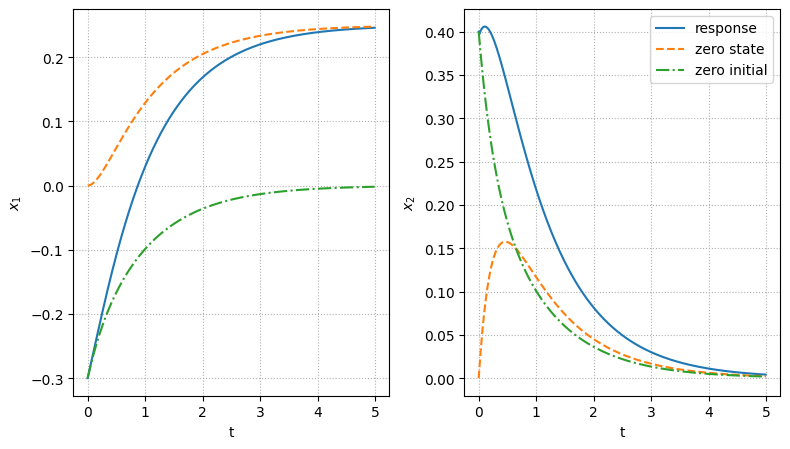

In [20]:
Td = np.arange(0, 5, 0.01)
Ud = 1 * (Td > 0)
X0 = [-0.3, 0.4]

xst, t = step(P, Td)
xin, _ = initial(P, Td, X0)
x, _, _ = lsim(P, Ud, Td, X0)

fig, ax = plt.subplots(1, 2, figsize=(8, 4.6))
for i in [0, 1]:
    ax[i].plot(t, x[:, i], label='response')
    ax[i].plot(t, xst[:, i], ls='--', label='zero state')
    ax[i].plot(t, xin[:, i], ls='-.', label='zero initial')

plot_set(ax[0], 't', '$x_1$')
plot_set(ax[1], 't', '$x_2$', 'best')
fig.tight_layout()

<h2>まとめ</h2>

- 状態空間モデルは入力に対しての出力の変化の他に、初期値が出力（多分、そのあと）の結果にどう影響するかを確認することができる。
- 状態方程式$x(t) = e^{At}x(0) + \int_{0}^{t}e^{A(t-\tau)}Bu(\tau)d\tau$において、第1項を零入力状態、第2項を零状態応答と呼び、これらを足し合わせることで時間応答を見ることができる。

<h2>練習問題</h2>

$u(t)=3\sin5t$で$x(0)=[0.5, 1]^T$としたときの時間応答を確認します。

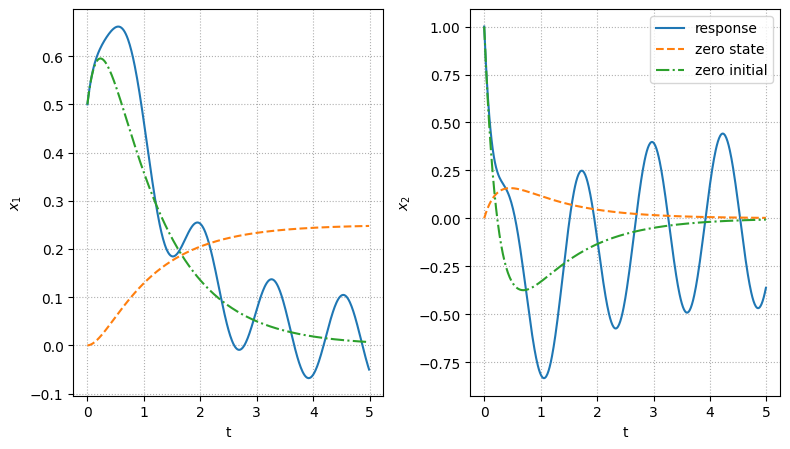

In [22]:
Td = np.arange(0, 5, 0.01)

# Difference of cell as above and now practice probrem is the Ud and the X0 variables.
Ud = 3 * np.sin((5*Td))
X0 = [0.5, 1]

xst, t = step(P, Td)
xin, _ = initial(P, Td, X0)
x, _, _ = lsim(P, Ud, Td, X0)

fig, ax = plt.subplots(1, 2, figsize=(8, 4.6))
for i in [0, 1]:
    ax[i].plot(t, x[:, i], label='response')
    ax[i].plot(t, xst[:, i], ls='--', label='zero state')
    ax[i].plot(t, xin[:, i], ls='-.', label='zero initial')

plot_set(ax[0], 't', '$x_1$')
plot_set(ax[1], 't', '$x_2$', 'best')
fig.tight_layout()